<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [451]:
import numpy as np
import pandas as pd
import itertools
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy import interpolate
import scipy.stats
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
import seaborn as sns
warnings.filterwarnings("ignore")

from scipy.interpolate import CubicSpline
from matplotlib.pyplot import figure
from numpy.random import normal
import numpy as np

Instructions: Fit splines into single features in your project data. Explore options to obtain the best fit

In [452]:
#función que calcula la predicción Y[] de un X[] usando los parametros o coeficientes de regresión beta[]
def pronostica(params,X): #params:parámetros de regresión; X:datos de regresores 
    y = []
    i = 0
    for rows in X:
        y.append(np.matmul(params,X[i]))
        i = i + 1
    return(y)

In [453]:
def dibuja_hist(df,colour,name,Xlabel,Ylabel,title):
    plt.figure()
    df.hist(column=0, bins=25, grid=False, figsize=(6,3), color=colour, zorder=2, rwidth=0.9)
    plt.xticks(rotation=90)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    #https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors/42020486
    mytitle = plt.title(title) # get the title property handler   #plt.getp(title_obj)  
    plt.setp(mytitle, color='#ff8000')                            # set the color of title
    myax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
    myax.xaxis.label.set_color('#ff8000')
    myax.yaxis.label.set_color('#ff8000')
    myax.tick_params(colors='#ff8000', which='both')              # myax.spines['bottom'].set_color('yellow')
    plt.savefig(name, transparent=True)
    plt.show()                                                    # o plt.save_en_algún_formato()

## Regresión spline en predicción de demanda eléctrica

A continuación aplicaremos técnicas de expansión de base aplicados a predicción de demanda eléctrica por regresión, tal como se hizo en el la [tarea 3](https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea3.ipynb#scrollTo=Ext-myaET2n5). Recordando que la variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación. Compararemos el desempeño de usar transformación variables y algunas tpecnicas de reducción de dimensiones como **stepwise**.

Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

In [454]:
df = pd.read_csv('demanda.csv')

In [455]:
## Procesamos datos de entrenamiento 
df1 = df.loc[df.iloc[:,19].isin(['T'])] ## 'T' = training set
df2 = df1['Y']  
df1 = df1[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

Ahora, cargamos los datos de prueba en los arreglos `X_train` y `y_train`:

In [456]:
## Procesamos datos de prueba 
dft = df.loc[df.iloc[:,19].isin(['F'])] ## 'F' = test set
dft2 = dft['Y']
dft1 = dft[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

In [457]:
df1.std(numeric_only = True) 
df1.mean(numeric_only = True)
df1 = df1 - df1.mean(numeric_only = True)
df1 = df1 / df1.std(numeric_only = True) 
X_train = df1.to_numpy()   ## Predictors
X_train = sm.add_constant(X_train)
y_train = df2.to_numpy()   ## Outcome

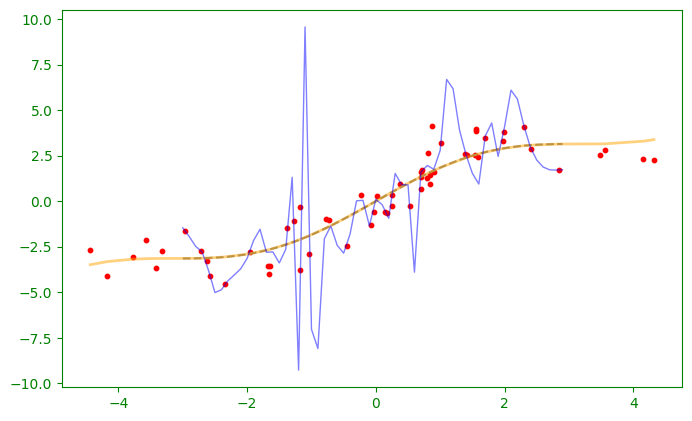

In [467]:
figure(figsize = (8, 5), dpi = 100)
xt = np.arange(-3, 3, 0.1) # true x coordinates
n  = len(xt)
magnitude = 1 ## noise
x  = np.sort(xt + normal(size = n, scale = magnitude)) # add noise and SORT
yt = np.sin(xt) + xt                                   # true y coordinates
y  = yt + normal(size = n, scale = magnitude)          # add noise

st = CubicSpline(xt, yt) # fit a cubic spline to the pure data
s  = CubicSpline(x,  y)  # fit a cubic spline to the noisy data

plt.rcParams.update({'text.color': 'green',
                     'xtick.color': 'green',
                     'ytick.color': 'green',
                     'axes.labelcolor': 'green',
                     'axes.edgecolor': 'green',
                     'axes.facecolor':  'none' })
plt.scatter(x, y,      c = 'red'   , s = 10) # data

plt.plot(   xt, yt,    c = 'gray'  , linestyle = 'dashed')       # pure model
plt.plot(   x, st(x),  c = 'orange', linewidth = 2, alpha = 0.5) # clean spline
plt.plot(   xt, s(xt), c = 'blue'  , linewidth = 1, alpha = 0.5) # noisy spline
plt.savefig('spline.png', transparent = True)

In [471]:
x    = np.arange(len(X_train[:,9]))
y    = X_train[:,9]
tck  = interpolate.splrep(x, y, s=0)
tck  = interpolate.splrep(x, y, s=0)
ynew = interpolate.splev(x, tck, der=0)
ycs = CubicSpline(x, y)
yder = interpolate.splev(x, tck, der=2)

No handles with labels found to put in legend.


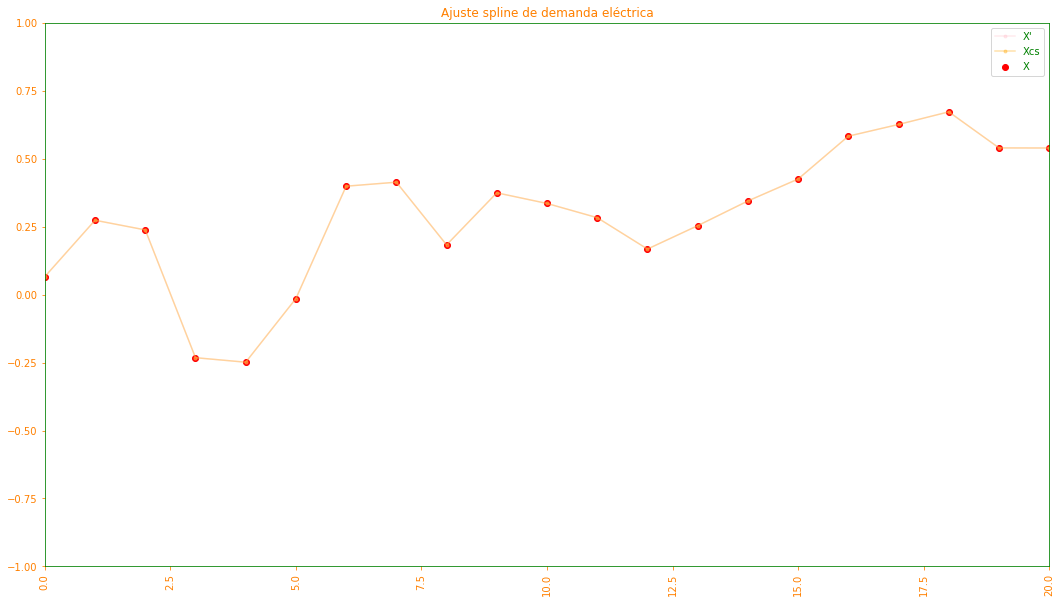

In [473]:
fig  = plt.figure(figsize=(18,10))
axes = fig.add_subplot(1, 1, 1)
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'
mytitle = plt.title('Ajuste spline de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color='#ff8000')                                        #set the color of title to red
axes.xaxis.label.set_color('#ff8000')
axes.yaxis.label.set_color('#ff8000')
axes.tick_params(   colors='#ff8000', which='both')

plt.scatter( x , y , color = 'red'   , label = 'X'    )

axes.plot( x , ynew   , '.-', color = 'pink'   , label = 'X\''   ,alpha=1/3)
axes.plot( x , ycs(x) , '.-', color = 'orange' , label = 'Xcs'   ,alpha=1/3)

plt.axis([0, 20, -1, 1])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda.png', transparent=True)
#plt.legend(['Linear', 'Cubic Spline'])  
plt.show()

Estandarizamos los datos de los regresores `X_train` y `X_test` restando la media y dividiendo entre la varianza.

A continuación, obtenemos un modelo de predicción de los datos de entrenamiento usando regresión lineal.

In [461]:
model   = sm.OLS(y_train, X_train)
results = model.fit()
#print(results.summary()) 
#print(results.params)

Ahora, calculamos los errores entre la predicción `y_pred` y los datos de entrenamiento `y_train`. Los errores son representados por un histograma.

In [462]:
y_pred     = pronostica(results.params,X_train)
error      = y_train - y_pred
err_train  = mean_absolute_error(y_pred,y_train)
bias_train = bias.bias(y_pred,y_train, axis=0)
df         = pd.DataFrame(error,y_train)

<Figure size 432x288 with 0 Axes>

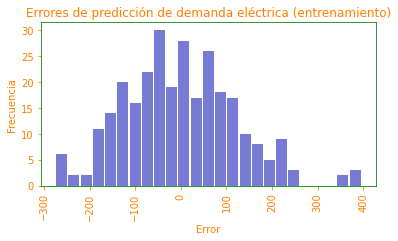

In [463]:
dibuja_hist(df,colour='#777bd4',name='hist11.png',Xlabel="Error",Ylabel="Frecuencia",title="Errores de predicción de demanda eléctrica (entrenamiento)")

Ahora, utilizamos el modelo obtenido con los datos de entrenamiento para predecir los datos de prueba. Además,  calculamos los errores entre la predicción `y_pred2` y los datos de prueba $Yt$. Los errores de la predicción con datos de prueba son representados por un histograma.

In [464]:
y_pred2   = pronostica(results.params,X_test) #print(y_pred2)
error2    = y_test - y_pred2
err_test  = mean_absolute_error(y_test,y_pred2)
bias_test = bias.bias(y_test,y_pred2,axis=0)
df        = pd.DataFrame(error2,y_test)

NameError: ignored

In [ ]:
dibuja_hist(df,colour='#76ced6',name='hist12.png',Xlabel="Error",Ylabel="Frecuencia",title="Errores de predicción de demanda eléctrica (prueba)")

Ahora, comparamos el **error absoluto medio (MAE)** y **bias** de los datos de entrenamiento así como de los datos de prueba en la predicción de demanda eléctrica.

In [ ]:
print("MAE y bias del modelo de regresión con datos de entrenamiento:", err_train, "," , bias_train)
print("MAE y bias del modelo de regresión con datos de prueba:" , err_test, "," , bias_test) 